# 1. 使用伯努利分布的最优推断法
![伯努利分布](./data/learn_WML_chapter_7_伯努利分布.jpg "伯努利分布")

In [ ]:
# download mnist dataset
# 如果这里下载失败请手动下载这两个文件放置到data目录下
import requests
train_images=requests.get(url="http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")
with open("./data/train-images-idx3-ubyte.gz","wb") as f:
    f.write(train_images.content)
train_labels=requests.get(url="http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")
with open("./data/train-labels-idx1-ubyte.gz","wb") as f:
    f.write(train_labels.content)

In [1]:
import gzip
import numpy as np
import struct
import matplotlib.pyplot as plt
import pandas as pd

def read_data(lable_url, image_url):
    # open label file
    with gzip.open(lable_url) as flbl:
        # read file header
        magic, num = struct.unpack(">II", flbl.read(8))
        label = np.frombuffer(flbl.read(), dtype=np.int8)
    # open image file
    with gzip.open(image_url) as fimg:
        # read image file header
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        image = np.frombuffer(fimg.read(), dtype=np.uint8)
        image = image.reshape(len(label), 1, rows, cols)
        # data normalization: from (0,255) to (0,1)
        # image = image.astype(np.float) / 255.0
    return (label, image)

In [198]:
labels,images=read_data("./data/train-labels-idx1-ubyte.gz","./data/train-images-idx3-ubyte.gz")

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


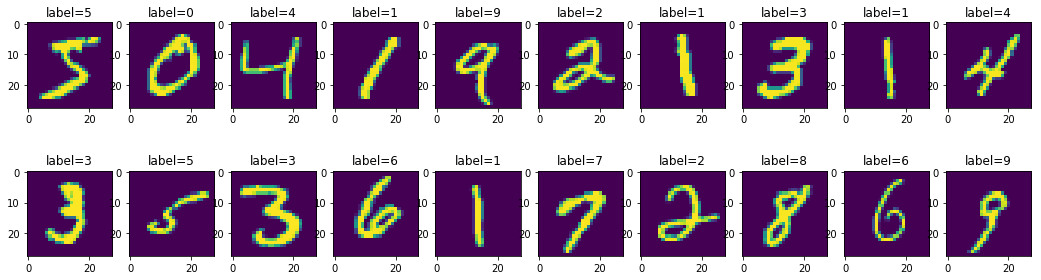

In [193]:
# examples of data
shape=images.shape[-2:]
fig=plt.figure(figsize=(18,5))
for i in range(20):
    img=images[i].reshape(shape)
    subplot=fig.add_subplot(2,10,i+1)
    subplot.imshow(img)
    subplot.set_title("label={}".format(labels[i]))
fig.show()

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


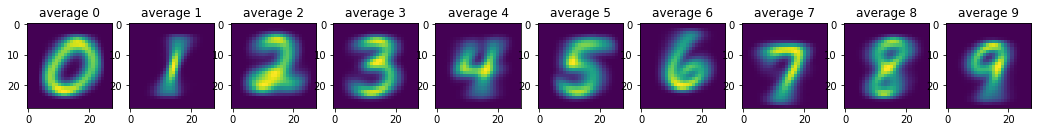

In [194]:
c=[[],[],[],[],[],[],[],[],[],[]]
# 求和
for i in range(len(labels)):
    index=labels[i]
    c[index].append(images[i].reshape(28,28))
# 求平均
mu=[]
for i in range(len(count)):
    mu.append(sum_images[i]/count[i])
# 显示
fig=plt.figure(figsize=(18,5))
for number in range(10):
    x=np.array([0]*28*28).reshape(28,28)
    for i in c[number]:
        x+=i
    v=(x/len(c[number])).astype(np.uint8)
    subplot=fig.add_subplot(1,10,number+1)
    subplot.imshow(v)
    subplot.set_title("average {}".format(number))
fig.show()
fig.savefig("./data/averageFaceOfNumber.png",dpi=300)

# 2. 混合分布最优推断法
![混合伯努利分布](./data/learn_WML_chapter_7_混合伯努利分布.jpg "混合伯努利分布")

In [23]:
# 伯努利分布
def bern(x,mu):
    r=1.0
    for x_i,mu_i in zip(x,mu):
        if x_i==1:
            r*=mu_i
        else:
            r*=(1.0-mu_i)
    return r
# 画出效果图
def show_images(mu):
    fig=plt.figure(figsize=(18,5))
    K=len(mu)
    for i in range(K):
        subplot=fig.add_subplot(1,K,i+1)
        subplot.set_xticks([])
        subplot.set_yticks([])
        subplot.imshow(mu[i].reshape(28,28),cmap=plt.cm.gray_r)
        subplot.set_title("average {}".format(i))
    fig.show()

# 主函数
def run_em(K,mix,mu,data):
    data_num=len(data)
    resp=pd.DataFrame()
    # E phrase
    for index,line in data.iterrows():
        tmp=[]
        for k in range(K):
            a=mix[k]*bern(line,mu[k])
            if a==0:
                tmp.append(0.0)
            else:
                s=0.0
                for kk in range(K):
                    s+=mix[kk]*bern(line,mu[kk])
                tmp.append(a/s)
        resp=resp.append([tmp],ignore_index=True)
    # M phrase
    new_mu=np.zeros((K,28*28))
    new_mix=np.zeros(K)
    for k in range(K):
        nk=resp[k].sum()
        new_mix[k]=nk/data_num
        for index,line in data.iterrows():
            new_mu[k]+=line*resp[k][index]
        new_mu/=nk
    
    cls=[]
    for index,line in data.iterrows():
        cls.append(np.argmax(line[0:]))
    
    return new_mix,new_mu,cls

In [9]:
labels,images=read_data("./data/train-labels-idx1-ubyte.gz","./data/train-images-idx3-ubyte.gz")
images=images[5000]
data=pd.DataFrame([list(image.reshape(28*28)) for image in images])

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


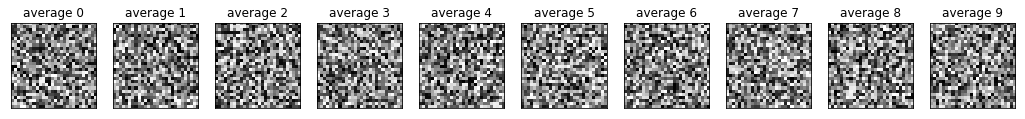

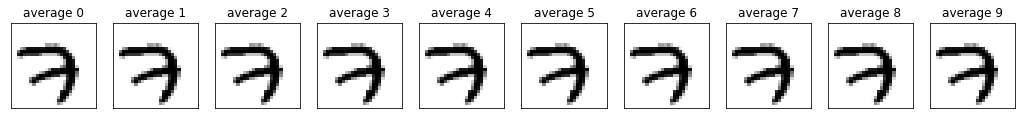

In [24]:
# 随机初始化的图像生成器: mu
K=10 # 0-9 一共10种数字
mix=[1.0/K]*K
mu=np.array(np.random.rand(K*28*28)*0.5+0.25).reshape(K,28*28)
for k in range(K):
    mu[k]/=mu[k].sum()
show_images(mu)
mix, mu, cls = run_em(K, mix, mu, data)
show_images(mu)